# Orcid Adoption in Ireland
*by Neil Tynan @ATU*

![ORCiD](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.infodocket.com%2Fwp-content%2Fuploads%2F2020%2F11%2F1200px-ORCID_logo.svg_.png&f=1&nofb=1&ipt=deaeedbc3fcf61e94115e9f869a818bc3bc936d6d83f98f831c3669dd21c1e63&ipo=images)
###### *“Logo provided by ORCiD and used in line with the ORCID brand guidelines”*

ORCiD is a free, unique, persistent identifier (PID) that researchers use to track their research, scholarship, and innovation activities. As a PID, ORCiD helps universities, funders and governments stay up to date with their researchers’ outputs via a large database of trustworthy, vertified data. Conseuqently, many funders, such as Science Foundation Ireland, have increasingly made having an ORCiD a require for applying for grant funding. This has a substantive impact on the availability of data on Ireland's research ecosystem. This presents an interesting question, if all researchers in Ireland were obliged to follow SFI's policies on presenting their ORCiDs, how many Irish research ORCiDs would be publically available in institutional and Irish governmental data sources?

This project aims to answer this question by looking at two different data sources, which deal with researchers in Ireland*. The sources in question are:
- The Organisation for Economic Co-operation and Development (OECD)'s [Main Science and Technology Indicators (MSTI) database] (https://data-explorer.oecd.org/vis?lc=en&tm=researchers&pg=0&snb=213&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_MSTI%40DF_MSTI&df[ag]=OECD.STI.STP&df[vs]=1.3&dq=.A.G%2BT_RS...&lom=LASTNPERIODS&lo=5&to[TIME_PERIOD]=false) 
- Science Foundation Ireland (SFI)'s [Grant Commitment List](https://data.gov.ie/dataset/science-foundation-ireland-grants-commitments)

The analysis looks at the data for both sources between 2001-2023 (see READMe for more details on the timeframe) and aims to use the OECD data on the number of active researchers in Ireland and the SFI data on the percentage of SFI grant awardees presenting their ORCiDs to work out an estimate for the percentage of Irish researchers who would be presenting ORCiDs if SFI's policies were rolled out across the board in Ireland. That means there are three key questions to answer in this project:
1. How many active researchers are there in Ireland over the outlined period?
2. What percentage of SFI grant awardees are presenting ORCiDs?
3. If we apply the SFI percentage to the number of researchers in Ireland, what is the estimate for the overall number of Irish researchers would be presenting an ORCiD?

That should present us with all of the data that we need to answer our core question.

**The authors original intention was also to use data from ORCiD's own API (for obvious reasons). However, for certain data security and data license reasons, it was decided to not take this approach.* 

## Import Libraries
---

In [41]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests
from io import StringIO
from sklearn.linear_model import LinearRegression

## 1. Number of Active Researchers in Ireland
---

First off, we need to determine the number of active researchers in Ireland over the course of the timeframe. The Central Statistics Office provides annual data to the OECD on research activity in Ireland. So, we should be able to pull the data directly from the OECD's API.

In [42]:
# Load in OECD Data
oecdapi = "https://sdmx.oecd.org/public/rest/data/OECD.STI.STP,DSD_RDS_PERS@DF_PERS_FUNC,/.A.._T..._T.._T..PS_FTE?startPeriod=2001&format=csvfilewithlabels"
response = requests.get(oecdapi)
oecd_data = StringIO(response.text)
oecd = pd.read_csv(oecd_data)
oecd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 858 non-null    object 
 1   STRUCTURE_ID              858 non-null    object 
 2   STRUCTURE_NAME            858 non-null    object 
 3   ACTION                    858 non-null    object 
 4   REF_AREA                  858 non-null    object 
 5   Reference area            858 non-null    object 
 6   FREQ                      858 non-null    object 
 7   Frequency of observation  858 non-null    object 
 8   MEASURE                   858 non-null    object 
 9   Measure                   858 non-null    object 
 10  SECT_PERF                 858 non-null    object 
 11  Sector of performance     858 non-null    object 
 12  FORD                      858 non-null    object 
 13  Field of R&D              858 non-null    object 
 14  ACTIVITY  

Now that we have the data, we need to clean so that we are only refrencing the data relevant to Ireland. Then we can start to graph it.

In [43]:
# Seperate out Irish data
irl = oecd[oecd['Reference area'] == 'Ireland']

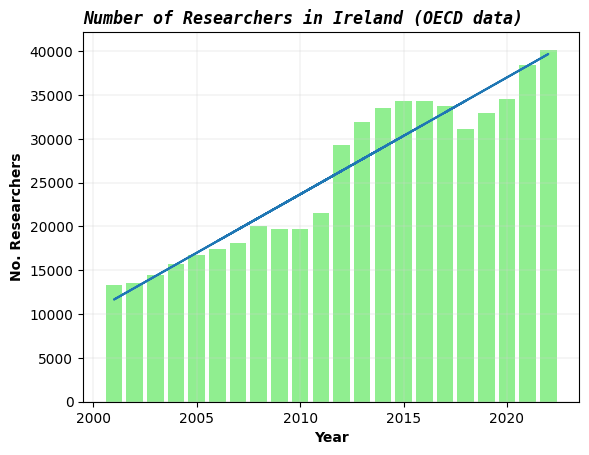

In [44]:
# Generate Bar Chart
plt.bar(irl['TIME_PERIOD'], irl['OBS_VALUE'], color='lightgreen')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("No. Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of Researchers in Ireland (OECD data)', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(irl['TIME_PERIOD'], irl['OBS_VALUE'], 1)
p = np.poly1d(z)
plt.plot(irl['TIME_PERIOD'], p(irl['TIME_PERIOD']))

plt.show()

This gives us a good overview of how the number of researchers in Ireland has developed over time. As per the trendline, we can see a fairly steady increase in active researchers in Ireland throughout the surved period. However, there is still a problem with comparing this data against the SFI data. It is missing the data for 2023. We will have to model the data for this year using the data from previous years.

In [45]:
# model the linear progression of the OECD data
irl['years'] = (irl['TIME_PERIOD'] - irl['TIME_PERIOD'].min())
X = irl[['years']]
y = irl['OBS_VALUE']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

In [46]:
# use the model to predict the value for 2023
last_year = irl['TIME_PERIOD'].max()
new_year = (last_year + 1)
newX= (new_year - irl['TIME_PERIOD'].min())
next_year = model.predict([[newX]])

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [47]:
# add in the new data
new_row = {'TIME_PERIOD': 2023, 'OBS_VALUE': 41017} # rounding up 'OBS_VALUE' as this should be a whole value
irl.loc[len(irl)] = new_row

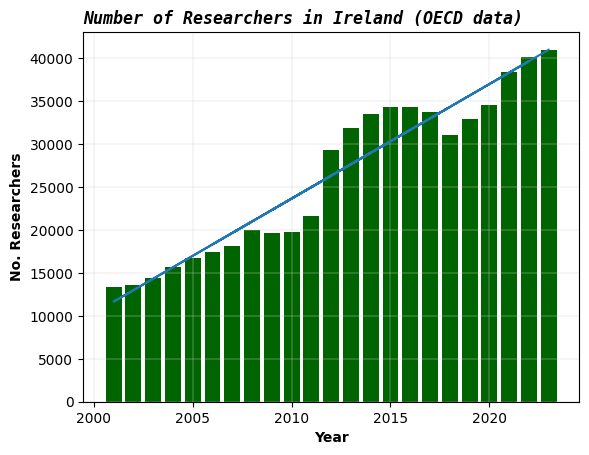

In [48]:
plt.bar(irl['TIME_PERIOD'], irl['OBS_VALUE'], color='darkgreen')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("No. Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of Researchers in Ireland (OECD data)', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(irl['TIME_PERIOD'], irl['OBS_VALUE'], 1)
p = np.poly1d(z)
plt.plot(irl['TIME_PERIOD'], p(irl['TIME_PERIOD']))
plt.show()

Now we have all the baseline data that we need to work out the answer to our core question. As already noted above, the data reflects a clear increase in the number of active researchers in Ireland between 2001-2023. Consequently, on the basis of pure numbers alone, we will probaly expect to see a rising number of Irish researchers presenting ORCiDs over time in our final estimate figure.

## 2. ORCID adoption amoung SFI Grant Holders
---

Now that we have the data for Ireland, we need to get the data for SFI next. Science Foundation Ireland published an annual data file every year on data.gov.ie which list details of the awards that were made that year. This includes a list of the year's awardees and their associated ORCiDs.

In [49]:
# Read in the Science Foundation Ireland Grant Committment List
url = "https://www.sfi.ie/about-us/governance/open-data/Open-Data-2023-11-30.csv"
sfi = pd.read_csv(url)
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Proposal ID                  6938 non-null   object
 1   Programme Name               6938 non-null   object
 2   Sub-Programme                2307 non-null   object
 3   Supplement                   1257 non-null   object
 4   Lead Applicant               6938 non-null   object
 5   ORCID                        5169 non-null   object
 6   Research Body                6938 non-null   object
 7   Research Body ROR ID         6637 non-null   object
 8   Funder Name                  6938 non-null   object
 9   Crossref Funder Registry ID  6938 non-null   object
 10  Proposal Title               6936 non-null   object
 11  Start Date                   6938 non-null   object
 12  End Date                     6938 non-null   object
 13   Current Total Commitment    6938

In [50]:
# Convert dates to datetime
sfi['Start Date'] = pd.to_datetime(sfi['Start Date'])
sfi['End Date'] = pd.to_datetime(sfi['End Date'])
sfi[' Current Total Commitment '] = sfi[' Current Total Commitment '].astype(str)
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Proposal ID                  6938 non-null   object        
 1   Programme Name               6938 non-null   object        
 2   Sub-Programme                2307 non-null   object        
 3   Supplement                   1257 non-null   object        
 4   Lead Applicant               6938 non-null   object        
 5   ORCID                        5169 non-null   object        
 6   Research Body                6938 non-null   object        
 7   Research Body ROR ID         6637 non-null   object        
 8   Funder Name                  6938 non-null   object        
 9   Crossref Funder Registry ID  6938 non-null   object        
 10  Proposal Title               6936 non-null   object        
 11  Start Date                   6938 non-null 

Having read the data and prepped it for use, we can now sperate out the ORCiD data for analysis.

In [51]:
# Pull out the ORCiD column
OID = sfi['ORCID']
OID.head(2)

0    https://orcid.org/0000-0002-8539-3143
1    https://orcid.org/0000-0003-3646-8222
Name: ORCID, dtype: object

In [52]:
# Seperate out those awardees with ORCiDs and those without
OIN = OID.isna()
OINS = OIN.sum()
print("Number of SFI Reseachers without an ORCiD:", OINS)

ONN = OID.notnull()
ONNS = ONN.sum()
print("Number of SFI Reseachers with an ORCiD:", ONNS)


Number of SFI Reseachers without an ORCiD: 1769
Number of SFI Reseachers with an ORCiD: 5169


Text(0.5, 1.0, 'Percentage of Historical SFI Grant Holders with an ORCiD')

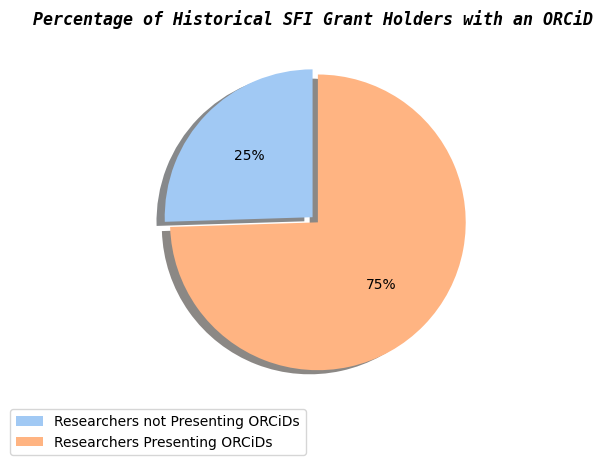

In [53]:
# Define data
data = [OINS, ONNS]
labels = ['Researchers not Presenting ORCiDs', 'Researchers Presenting ORCiDs']
explode = (0, 0.05)

# Define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

# Create pie chart
plt.pie(data, explode=explode, colors = colors, autopct='%.0f%%', shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.legend(labels, loc='best', bbox_to_anchor=(0, 0., 0.5, 0))
plt.title('Percentage of Historical SFI Grant Holders with an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'center') 


This give us the overall breakdown of the SFI grant data. However, it does not give us not give us the breakdown of the data by year that we need in order to contrast it with the overall data for Ireland. To get that, we will need to convert the data ranges into datetime and look at the data on an annual basis.

In [54]:
# Grouping the data into date blocks for analysis
SD = sfi['Start Date']
ONNY = ONN.groupby(SD.dt.year).sum()
OINY = OIN.groupby(SD.dt.year).sum()

# Adding in date ranges, as there is only partial data for 2024
dateFrom = "2001"
dateTo = "2023"

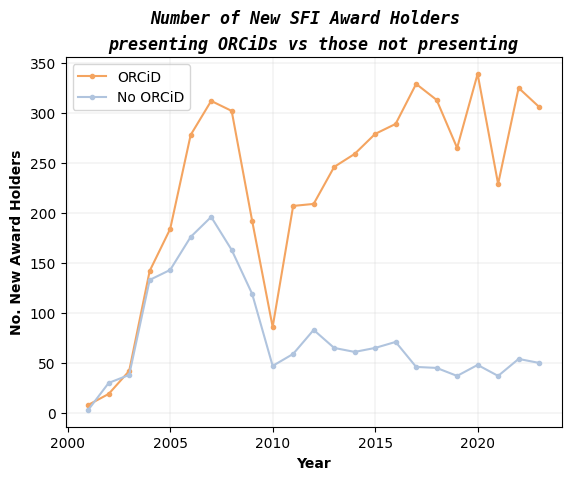

In [55]:
# Charting the SFI ORCiD data
plt1, = plt.plot(ONNY.loc[dateFrom:dateTo], marker='.', color='sandybrown')
plt2, = plt.plot(OINY.loc[dateFrom:dateTo], marker='.', color='lightsteelblue')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("No. New Award Holders", fontweight='bold')
plt.legend([plt1,plt2],["ORCiD", "No ORCiD"], loc = 'upper left')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.suptitle ('Number of New SFI Award Holders', fontweight='bold', style='italic', family='monospace')
plt.title('presenting ORCiDs vs those not presenting', fontweight='bold', style='italic', family='monospace')
plt.show()


That gives us the annual, year to year, data that we want. However, if we are planning to use this data with the OECD figures to make estimate of the national adoption rate, then we will need to convert these numbers into percentages before proceedding.

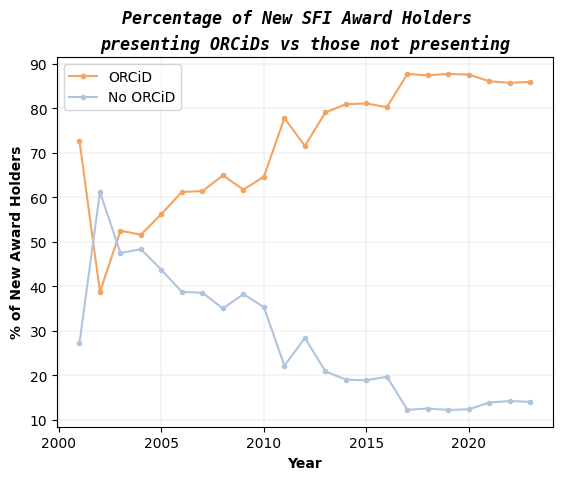

In [56]:
# Chart the SFI ORCiD data as a percentage
ONNT = ONNY.loc[dateFrom:dateTo] + OINY.loc[dateFrom:dateTo]
ONNYP = ONNY.loc[dateFrom:dateTo] / ONNT * 100
OINYP = OINY.loc[dateFrom:dateTo] / ONNT * 100

# Generate new chart
plt1, = plt.plot(ONNYP, marker='.', color='sandybrown')
plt2, = plt.plot(OINYP, marker='.', color='lightsteelblue')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("% of New Award Holders", fontweight='bold')
plt.legend([plt1, plt2], ["ORCiD", "No ORCiD"], loc='upper left')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.suptitle ('Percentage of New SFI Award Holders', fontweight='bold', style='italic', family='monospace')
plt.title('presenting ORCiDs vs those not presenting', fontweight='bold', style='italic', family='monospace')
plt.show()

Looking at things from a percentage perspective give us a pretty good idea of how ORCiD approval has progressed over time amoung SFI's researchers. Over the course of the 2000s-2010s, SFI was increasingly stringent about making researchers apply for an ORCiD before submitting an applications and that is reflected in the data. Some initial variance has given way to a clear trend: the number of awardees presenting an ORCiD has increased markedly over time, leading to a concurrent sharp drop in the numer of awardees who are not presenting an ORCiD. We should expect then that our final estimate will see a concurrent rise in the percentage of Irish researchers presenting an ORCiD over the course of the surveyed period.

Now that we have these percentages, we should also have the data that we need in order to make an estimate of what the national figures might look like.

## 3. Estimating a Figure for ORCiD Adoption in Ireland
---

For the final step, to work out the national estimate, the first thing we need to do is put together a new dataframe with the relevant OECD and SFI data. We can then use that new dataframe to work out an estimate for what the national approval level might look like.

In [57]:
# Generate new dataframe to merge relevant OECD and SFI data
df = pd.DataFrame(irl.loc[:, ["OBS_VALUE","TIME_PERIOD"]])
dff = df.set_index('TIME_PERIOD')
per = pd.DataFrame(ONNYP/100)
per.rename(columns={'ORCID': 'ORCPer'}, inplace=True)
per2 = pd.DataFrame(OINYP/100)
per2.rename(columns={'ORCID': 'NoORCPer'}, inplace=True)
hold = pd.merge(per, dff, left_index=True, right_index=True)
data = pd.merge(hold, per2, left_index=True, right_index=True)

# Create new columns based off the overall IRL researcher numbers and the percentage of SFI awardees with ORCiDs
data['ORCiD'] = data.OBS_VALUE * data["ORCPer"]
data['NoORCiD'] = data.OBS_VALUE * data["NoORCPer"]

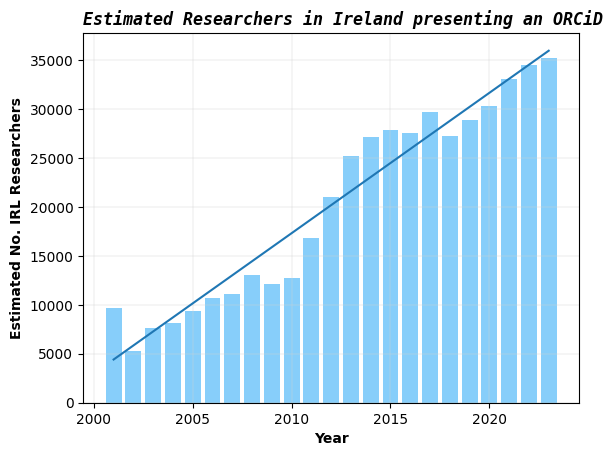

In [58]:
# Generate Bar Chart for estimated IRL Researchers with ORCiDs
plt.bar(data.index, data['ORCiD'], color='lightskyblue')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Estimated No. IRL Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Estimated Researchers in Ireland presenting an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(data.index, data['ORCiD'], 1)
p = np.poly1d(z)
plt.plot(data.index, p(data.index))
plt.show()

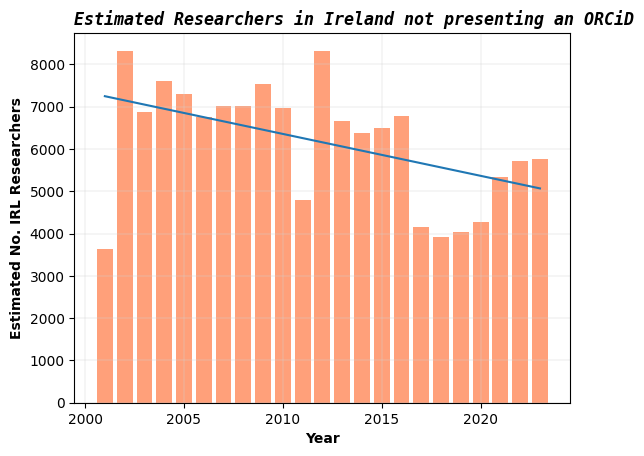

In [59]:
# Generate Bar Chart for estimated IRL Researchers without an ORCiD
plt.bar(data.index, data['NoORCiD'], color='lightsalmon')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Estimated No. IRL Researchers", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Estimated Researchers in Ireland not presenting an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(data.index, data['NoORCiD'], 1)
p = np.poly1d(z)
plt.plot(data.index, p(data.index))
plt.show()

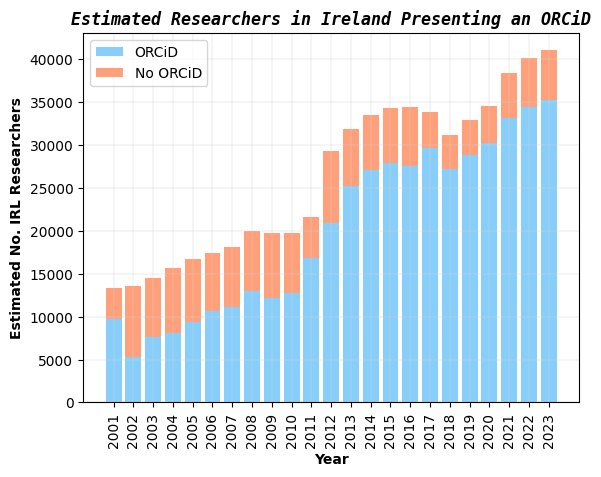

In [60]:
# Generate stacked bar chart for easy comparison of the overall numbers in both categories
fig, ax = plt.subplots()
ax.bar(data.index, data["ORCiD"], label='ORCiD', color='lightskyblue')
ax.bar(data.index, data["NoORCiD"], bottom=data["ORCiD"], label='No ORCiD', color='lightsalmon')
ax.set_title("Estimated Researchers in Ireland Presenting an ORCiD", fontweight='bold', style='italic', family='monospace')
ax.set_xlabel("Year", fontweight='bold')
ax.set_ylabel("Estimated No. IRL Researchers", fontweight='bold')
ax.grid(color='lightgrey', linestyle='-', linewidth=0.3)
ax.set_xticks(data.index)
ax.set_xticklabels(data.index, rotation=90)  
ax.legend()

The resuls are largely what would be expected given the earlier results. The estimated number of researchers presenting ORCiDs rises substantially in both percentage and real terms between 2001-2023. 

It is worth noting that there are some limitations to our results. SFI largerly funded STEM activity, so the results here may not be as applicable to researchers in other areas. The OECD data also does not capture all active researchers in Ireland, just those whose primary role identifies them as one. There may, consequently, be substantive variance between the actual ORCiD figures for Ireland and the estimates seen here.

However, taking all of that into account, the reseults do seem to indicate that, on some level,Ireland's research ecosystem is likely well integrated into ORCiDs network and that there is substantive data which can be accessed via ORCiD's API that may be of use in institutional and national planning.

# END